<h1>Currently working in it...... # 12 January 2024</h1>
<br><h3>----This Notebook Contain Sample For 6 Parameter using COBAYA</h3>

In [1]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
import emcee

In [2]:
#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

In [12]:
def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

In [15]:
print(Cosmo_Power(0.022,0.12,68,0.0546,0.964,2.01))

930.6118509511323


In [16]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"ring": Cosmo_Power}}
info["params"] = {
    "omb": {"prior": {"min": 0.01, "max": 0.025}, "ref": 0.022, "proposal": 0.001},
    "omc": {"prior": {"min": 0.1, "max": 0.15}, "ref": 0.12, "proposal": 0.01},
    "h": {"prior": {"min": 65, "max": 67}, "ref": 66, "proposal": 0.1},
    "tau": {"prior": {"min": 0.05, "max": 0.06}, "ref": 0.054, "proposal": 0.001},
    "ns": {"prior": {"min": 0.8, "max": 1}, "ref": 0.945, "proposal": 0.01},
    "As": {"prior": {"min": 1.8, "max": 2.2}, "ref": 2.0196, "proposal": 0.01}}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}

In [13]:
from cobaya import run
updated_info, sampler = run(info)

[ring] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: omb:0.022, omc:0.12, h:66, tau:0.054, ns:0.945, As:2.0196
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {ring: 187.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-01-12 21:30:54 : 1 steps taken, and 0 accepted.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.575
[mcmc]  - Convergence of means: R-1 = 8.322044 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.445
[mcmc]  - Convergence of means: R-1 = 2.912221 after 384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 720 samples accepted.
[mcmc]  - Acceptance rate: 0.361
[mcmc]  - Convergence of means: R-1 = 1.715602 after 576 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 960 samples accepted.
[mcmc]  - Acceptance rate: 0.332
[mcmc]  - Convergence of means: R-1 = 0.340683 after 768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1200 samples accepted.
[mcmc]  - Acceptance rate: 0.307
[mcmc]  - Convergence of means: R-1 = 0.200767 after 9

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* auto bandwidth for omc very small or failed (h=0.0005789072948721767,N_eff=23374.712644714175). Using fallback (h=0.05370028235560089)
[root] *WARNING* auto bandwidth for tau very small or failed (h=0.000512051768127531,N_eff=23304.47794093745). Using fallback (h=0.053706879515016195)
[root] *WARNING* auto bandwidth for ns very small or failed (h=0.0005606019057760746,N_eff=23701.608080178994). Using fallback (h=0.053244260297513356)


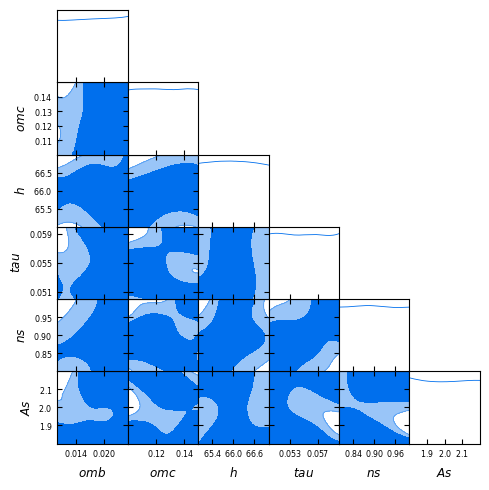

In [14]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb", "omc","h","tau","ns","As"], filled=True)